# Imports & Setups

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from math import ceil

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,Imputer
from sklearn.metrics import confusion_matrix,f1_score,roc_auc_score

import warnings 

In [2]:
sns.set()
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 7)

# Helper functions

## Visualization

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Reduce memory usage

In [4]:
def convert_col_to_proper_int(df_col):
    col_type = df_col.dtype
#     print('convert_col_to_proper_int column: ', df_col.name, 'type: ', col_type, 'c_min: ', c_min)
    if ((str(col_type)[:3] == 'int') | (str(col_type)[:4] == 'uint')): # | (str(col_type)[:5] == 'float')
        c_min = df_col.min()
        c_max = df_col.max()
        if c_min < 0:
#             print('c_min: ', c_min, 'less 0')
            if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                df_col = df_col.astype(np.int8)
            elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                df_col = df_col.astype(np.int16)
            elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                df_col = df_col.astype(np.int32)
            elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                df_col = df_col.astype(np.int64)
        else:
#             print('c_min: ', c_min, 'not less 0')
            if c_max <= np.iinfo(np.uint8).max:
                df_col = df_col.astype(np.uint8)
            elif c_max <= np.iinfo(np.uint16).max:
                df_col = df_col.astype(np.uint16)
            elif c_max <= np.iinfo(np.uint32).max:
                df_col = df_col.astype(np.uint32)
            elif c_max <= np.iinfo(np.uint64).max:
                df_col = df_col.astype(np.uint64)
            
    return df_col

def convert_col_to_proper_float(df_col):
    col_type = df_col.dtype
    if str(col_type)[:5] == 'float':
        unique_count = len(np.unique(df_col))
        df_col_temp = df_col.astype(np.float32)
        if len(np.unique(df_col_temp)) == unique_count:
            df_col = df_col_temp
            c_min = df_col.min()
            c_max = df_col.max()
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df_col_temp = df_col.astype(np.float16)
                if len(np.unique(df_col_temp)) == unique_count:
                    df_col = df_col_temp
            
    return df_col

def float_to_int(df):
    """ iterate through all float columns of a dataframe and modify the data type
        to reduce memory usage.
    """
#     print('Begin float_to_int')
    for col in df.columns:
        col_type = df[col].dtype
#         print('column: ', col, 'type: ', col_type)
        if str(col_type)[:5] == 'float':
            if (df[col] % 1 == 0).all():
                df[col] = convert_col_to_proper_int(df[col].astype(np.int64))
    
    return df

def float_reduced(df):
    """ iterate through all float columns of a dataframe and modify the data type
        to reduce memory usage.
    """
#     print('Begin float_reduced')
    for col in df.columns:
        col_type = df[col].dtype
#         print('column: ', col, 'type: ', col_type)
        if str(col_type)[:5] == 'float':
            df[col] = convert_col_to_proper_float(df[col])
    
    return df

def int_reduced(df):
    """ iterate through all int columns of a dataframe and modify the data type
        to reduce memory usage.
    """
#     print('Begin float_reduced')
    for col in df.columns:
        df[col] = convert_col_to_proper_int(df[col])
    
    return df

def gentle_reduce_mem_usage(data, verbose = True):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))

    for col in data.columns:
#         print(col, type(data[col]), data[col].shape)
        col_type = data[col].dtype

        if ((col_type != object) & (col_type != '<M8[ns]') & (col_type.name != 'category')):#
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                data[col] = convert_col_to_proper_int(data[col])
            else:
                if (data[col] % 1 == 0).all():
                    data[col] = convert_col_to_proper_int(data[col].astype(np.int64))
                else:
                    data[col] = convert_col_to_proper_float(data[col])
        else: 
            try:
                data[col] = data[col].astype(np.float64)
                if (data[col] % 1 == 0).all():
                    data[col] = convert_col_to_proper_int(data[col].astype(np.int64))
                else:
                    data[col] = convert_col_to_proper_float(data[col])
            except:
                data[col] = data[col].astype('category')

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return data

## Columns Info

In [5]:
# Info about columns
def feats_summary(df_):
    feats_to_exclude = [f for f in df_.columns if f in ['TARGET']]

    cat_cols  = [col for col in df_.columns if df_[col].dtype == 'object']
    cat_cols += [col for col in df_.columns if not pd.api.types.is_numeric_dtype(df_[col].dtype)]
    cat_cols  = list(set(cat_cols).difference(feats_to_exclude))

    num_cols = [col for col in df_.columns if pd.api.types.is_numeric_dtype(df_[col].dtype)]
    num_cols  = list(set(num_cols).difference(feats_to_exclude))
    print('''Columns summary (overall {}) : 
    1. Categorical: {}
    2. Numerical: {}
    3. Excluded: {}'''.format(len(df_.columns),len(cat_cols),len(num_cols),len(feats_to_exclude)))
    return feats_to_exclude,cat_cols,num_cols

In [6]:
def get_missing_report(df_):
    count_missing = df_.isnull().sum().values
    ratio_missing = count_missing / df_.shape[0]
    
    return pd.DataFrame(data = {'count_missing': count_missing, 
                                'ratio_missing': ratio_missing},
                        index = df_.columns.values)

## Imputation

In [7]:
def impute_df(df, imp_cols, strategy = 'median'):
    num_columns = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col].dtype)]   
    imp_cols = list(set(list(df.columns)) & set(imp_cols) & set(num_columns))
    
    df[imp_cols] = df[imp_cols].replace([np.inf, -np.inf], np.nan)
    
    imp = Imputer(strategy=strategy)
    imputed_df = pd.DataFrame(imp.fit_transform(df[imp_cols]),index = df.index)  
    return imputed_df

# Load data

Data source is https://archive.ics.uci.edu/ml/datasets/SECOM

In [8]:
df_raw = pd.read_csv('./input/secom.data',sep=' ',header=None)
labels = pd.read_csv('./input/secom_labels.data',sep=' ',header=None,usecols=[0],squeeze = True)
df_raw['TARGET'] = labels
df_raw.shape

(1567, 591)

In [9]:
df_raw.head()

,0,1,2,...,588,589,TARGET
0,3030.93,2564.00,2187.7333,...,NaN,NaN,-1
1,3095.78,2465.14,2230.4222,...,0.0060,208.2045,-1
2,2932.61,2559.94,2186.4111,...,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,...,0.0044,73.8432,-1
4,3032.24,2502.87,2233.3667,...,0.0044,73.8432,-1


In [10]:
df_raw['TARGET'].value_counts()

-1    1463
 1     104
Name: TARGET, dtype: int64

# Dataframe Transformation

In [11]:
df = df_raw.copy()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 591 entries, 0 to TARGET
dtypes: float64(590), int64(1)
memory usage: 7.1 MB


In [13]:
df = gentle_reduce_mem_usage(df)

Memory usage of dataframe: 7.07 MB
Memory usage after optimization: 2.82 MB
Decreased by 60.0%


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 591 entries, 0 to TARGET
dtypes: float16(242), float32(345), float64(3), int8(1)
memory usage: 2.8 MB


# Train / test split

In [15]:
X = df.copy()
y = df['TARGET'].copy()
X.drop(['TARGET'],axis=1,inplace=True) # Exclude target variable from X dataframe

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train.shape,X_test.shape

((1253, 590), (314, 590))

# Exploratory data analysis

## Exploring missing values

For X_train:

In [16]:
get_missing_report(X_train).sort_values(by='ratio_missing',ascending=False).head(10)

,count_missing,ratio_missing
157,1138,0.908220
293,1138,0.908220
292,1138,0.908220
158,1138,0.908220
85,1070,0.853951
220,1070,0.853951
492,1070,0.853951
358,1070,0.853951
383,816,0.651237
110,816,0.651237


For X_test:

In [17]:
get_missing_report(X_test).sort_values(by='ratio_missing',ascending=False).head(10)

,count_missing,ratio_missing
158,291,0.926752
157,291,0.926752
293,291,0.926752
292,291,0.926752
492,271,0.863057
85,271,0.863057
358,271,0.863057
220,271,0.863057
516,202,0.643312
245,202,0.643312


In [18]:
# Drop columns from with 80% of NaNs
cutoff = 0.80
nan_cols_to_drop = X_train.columns[(((X_train.isnull().sum()/X_train.shape[0])>cutoff) | \
                                    ((X_test.isnull().sum()/X_test.shape[0])>cutoff))]

X_train.drop(nan_cols_to_drop,axis=1,inplace=True)
X_test.drop(nan_cols_to_drop,axis=1,inplace=True)

X_train.shape,X_test.shape

((1253, 582), (314, 582))

### Imputation of missing values

In [19]:
nan_cols = X_train.columns[X_train.isna().any()]
if len(nan_cols)>0:
    X_train[nan_cols] = impute_df(X_train,nan_cols,strategy='median')

nan_cols = list(X_test.columns[X_test.isna().any()])
if len(nan_cols)>0:
    X_test[nan_cols] = impute_df(X_test,nan_cols,strategy='median')

## Exploring constant values

In [20]:
const_cols = X_train.columns[(((X_train == X_train.iloc[0]).all())|\
                              (X_test == X_test.iloc[0]).all())]
print('Count of columns with constant value(dropped):',len(const_cols))

X_train.drop(const_cols,axis=1,inplace=True)
X_test.drop(const_cols,axis=1,inplace=True)

Count of columns with constant value(dropped): 178


## Correlation

In [21]:
# Find correlations with the target and sort
X_train['TARGET'] = y_train
correlations = X_train.corr()['TARGET'].sort_values(ascending = False)
X_train.drop(['TARGET'],axis=1,inplace=True)

# Display correlations
print('Most Positive Correlations:\n', correlations.head(5))
print('\nMost Negative Correlations:\n', correlations.tail(5))

Most Positive Correlations:
 TARGET    1.000000
103       0.166613
59        0.164126
431       0.140725
434       0.128902
Name: TARGET, dtype: float64

Most Negative Correlations:
 122   -0.089176
26    -0.099154
28    -0.100750
316   -0.102978
125   -0.103152
Name: TARGET, dtype: float64


# Normalization

In [22]:
_, cat_cols,num_cols = feats_summary(X_train)

Columns summary (overall 404) : 
    1. Categorical: 0
    2. Numerical: 404
    3. Excluded: 0


In [23]:
for col in num_cols:
    ss = StandardScaler()
    X_train[col] = ss.fit_transform(X_train[col].values.reshape(-1,1))
    X_test[col] = ss.fit_transform(X_test[col].values.reshape(-1,1))

# Modeling

In [24]:
logreg = LogisticRegression().fit(X_train, y_train)

In [25]:
logreg.score(X_train,y_train)

0.98164405426975254

In [26]:
logreg.score(X_test,y_test) # Score on test data

0.82802547770700641

# Scoring 

In [27]:
y_pred = logreg.predict(X_test)

In [28]:
f1_score(y_test, y_pred)

0.12903225806451615

In [29]:
roc_auc_score(y_test,y_pred)

0.52471264367816095

Confusion matrix, without normalization
[[256  34]
 [ 20   4]]
Normalized confusion matrix
[[ 0.88  0.12]
 [ 0.83  0.17]]


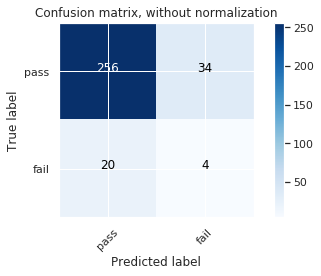

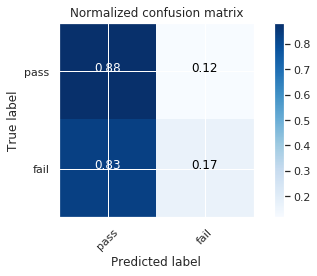

In [30]:
class_names = ['pass','fail']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()